<a href="https://colab.research.google.com/github/Ananyadevaraju/CE888---Assignment-1/blob/main/Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Bias in Machine Learning Algorithms

Importing libraries:

In [76]:
#import libraries

import pandas as pd
import numpy as np
from datetime import datetime 
#data visualization
import matplotlib.pyplot as plt
import seaborn as sns

#label encoder
from sklearn.preprocessing import LabelEncoder
#train-test-split and cross validation
from sklearn.model_selection import train_test_split, cross_val_score
#classifier
from sklearn.ensemble import RandomForestClassifier
#feature selection
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE

#scalers
from sklearn.preprocessing import StandardScaler

#aif360
#fairness metrics
# from aif360.metrics import BinaryLabelDatasetMetric
# from aif360.metrics import ClassificationMetric

#explainers
# from aif360.explainers import MetricTextExplainer

#bias mitigation techniques
# from aif360.algorithms.preprocessing import Reweighing
# from aif360.algorithms.inprocessing import PrejudiceRemover

#LIME - model interpretation
# from aif360.datasets.lime_encoder import LimeEncoder
# import lime
# from lime.lime_tabular import LimeTabularExplainer

pd.set_option('display.max_rows',1000)

Loading data:

This dataset is obtained from https://www1.nyc.gov/site/nypd/stats/reports-analysis/stopfrisk.page, which contains records of stop, question and frisk in 2019, from the NYPD database. The dataframe has 13,459 observations and infomration on 83 variables.

In [2]:
#load data 
df = pd.read_csv("https://raw.githubusercontent.com/Ananyadevaraju/CE888/main/Assignment_1/sqf-2019.csv")

In [3]:
#shape of the dataframe
df.shape

(13459, 83)

In [4]:
#columns names in the dataframe
df.columns

Index(['STOP_ID_ANONY', 'STOP_FRISK_DATE', 'STOP_FRISK_TIME', 'YEAR2',
       'MONTH2', 'DAY2', 'STOP_WAS_INITIATED', 'RECORD_STATUS_CODE',
       'ISSUING_OFFICER_RANK', 'ISSUING_OFFICER_COMMAND_CODE',
       'SUPERVISING_OFFICER_RANK', 'SUPERVISING_OFFICER_COMMAND_CODE',
       'LOCATION_IN_OUT_CODE', 'JURISDICTION_CODE', 'JURISDICTION_DESCRIPTION',
       'OBSERVED_DURATION_MINUTES', 'SUSPECTED_CRIME_DESCRIPTION',
       'STOP_DURATION_MINUTES', 'OFFICER_EXPLAINED_STOP_FLAG',
       'OFFICER_NOT_EXPLAINED_STOP_DESCRIPTION', 'OTHER_PERSON_STOPPED_FLAG',
       'SUSPECT_ARRESTED_FLAG', 'SUSPECT_ARREST_OFFENSE',
       'SUMMONS_ISSUED_FLAG', 'SUMMONS_OFFENSE_DESCRIPTION',
       'OFFICER_IN_UNIFORM_FLAG', 'ID_CARD_IDENTIFIES_OFFICER_FLAG',
       'SHIELD_IDENTIFIES_OFFICER_FLAG', 'VERBAL_IDENTIFIES_OFFICER_FLAG',
       'FRISKED_FLAG', 'SEARCHED_FLAG', 'ASK_FOR_CONSENT_FLG',
       'CONSENT_GIVEN_FLG', 'OTHER_CONTRABAND_FLAG', 'FIREARM_FLAG',
       'KNIFE_CUTTER_FLAG', 'OTHER_WEAPON_F

Missing data:

In [5]:
#checking for NaN values
df.isnull().sum()

STOP_ID_ANONY                     0
STOP_FRISK_DATE                   0
STOP_FRISK_TIME                   0
YEAR2                             0
MONTH2                            0
                                 ..
STOP_LOCATION_X                   0
STOP_LOCATION_Y                   0
STOP_LOCATION_ZIP_CODE            0
STOP_LOCATION_PATROL_BORO_NAME    0
STOP_LOCATION_BORO_NAME           0
Length: 83, dtype: int64

Drop columns:

In [7]:
df["YEAR2"].value_counts()

2019    13459
Name: YEAR2, dtype: int64

In [8]:
df["RECORD_STATUS_CODE"].value_counts()

APP    13459
Name: RECORD_STATUS_CODE, dtype: int64

In [9]:
df["PHYSICAL_FORCE_RESTRAINT_USED_FLAG"].value_counts()

(null)    13459
Name: PHYSICAL_FORCE_RESTRAINT_USED_FLAG, dtype: int64

In [10]:
#dropping columns with same class/value for all observations
stop_search_df = df.drop(columns = ["YEAR2", "RECORD_STATUS_CODE", "PHYSICAL_FORCE_RESTRAINT_USED_FLAG"], axis = 1)

In [11]:
#dropping redundant columns (example: code and its description for a feature)
stop_search_df = stop_search_df.drop(columns = ["JURISDICTION_CODE", "DEMEANOR_CODE"], axis = 1)

In [12]:
#dropping columns with information about the officers which are irrelevant for this study
stop_search_df.drop(columns = ["ID_CARD_IDENTIFIES_OFFICER_FLAG", "SHIELD_IDENTIFIES_OFFICER_FLAG", "VERBAL_IDENTIFIES_OFFICER_FLAG"], axis = 1, inplace = True) 

In [13]:
#dropping feature columns information on location which are not being used in this study(like latitude, longitude and retaining necessary information on location)
stop_search_df.drop(columns = ["STOP_LOCATION_APARTMENT", "STOP_LOCATION_FULL_ADDRESS", "STOP_LOCATION_X", "STOP_LOCATION_Y"], axis = 1, inplace = True)

In [19]:
stop_search_df.shape

(13459, 71)

Data transformation:



In [17]:
#gender feature - count of each class, male and female
stop_search_df["SUSPECT_SEX"].value_counts()

MALE       12179
FEMALE      1230
Unknown       50
Name: SUSPECT_SEX, dtype: int64

In [16]:
#replacing (null) values with Unknown
stop_search_df["SUSPECT_SEX"] = stop_search_df["SUSPECT_SEX"].replace(to_replace = ["(null)"], value = "Unknown")

In [20]:
#value counts of diffferent races stopped 
stop_search_df["SUSPECT_RACE_DESCRIPTION"].value_counts() 

BLACK                        7981
WHITE HISPANIC               2742
WHITE                        1215
BLACK HISPANIC               1127
ASIAN / PACIFIC ISLANDER      301
(null)                         85
AMERICAN INDIAN/ALASKAN N       8
Name: SUSPECT_RACE_DESCRIPTION, dtype: int64

In [25]:
#replace (null) values with Unknown
stop_search_df["SUSPECT_RACE_DESCRIPTION"] = stop_search_df["SUSPECT_RACE_DESCRIPTION"].replace(to_replace = ["(null)"], value = "Unknown")


#converting all classes other than Whites as Non-Whites - creating binary sensitive variable

race = []
for x in stop_search_df["SUSPECT_RACE_DESCRIPTION"]:
  if x == "WHITE":
    y = "White"  
  elif x == "Unknown":
    y = "Unknown"
  else:
    y = "Non-White"     
  race.append(y)       
  
stop_search_df["RACE"] = race              

#value_counts
stop_search_df["RACE"].value_counts() 

Non-White    12159
White         1215
Unknown         85
Name: RACE, dtype: int64

In [86]:
#extracting hour from time column
stop_search_df["Parts_of_day"] = pd.to_datetime(stop_search_df["STOP_FRISK_TIME"], format = "%H:%M:%S").dt.hour
#converting into day or not

#converting time into parts of day
Parts_of_day = []
for t in stop_search_df["Parts_of_day"]:
  if t >= 0 & t < 6:
    part = "Night"
  else:
    part = "Day"
  Parts_of_day.append(part)  

#adding new column "Parts_of_day" to the dataframe
stop_search_df["Parts_of_day"] = Parts_of_day

In [84]:
stop_search_df["Parts_of_day"].value_counts()

Night    13459
Name: Parts_of_day, dtype: int64

In [73]:
stop_search_df["Parts_of_day"].value_counts()

Night    13459
Name: Parts_of_day, dtype: int64

Is the data imbalanced?


In [35]:
#arrest feature count of each class
stop_search_df["SUSPECT_ARRESTED_FLAG"].value_counts()

N    9151
Y    4308
Name: SUSPECT_ARRESTED_FLAG, dtype: int64

In [36]:
#calculating imbalance in the data
total_y = len(stop_search_df["SUSPECT_ARRESTED_FLAG"])

class_0 = (stop_search_df["SUSPECT_ARRESTED_FLAG"] == "N").sum()
class_1 = (stop_search_df["SUSPECT_ARRESTED_FLAG"] == "Y").sum()

#imbalance in classes
percentage_class_0 = (class_0/total_y)*100
print("Percentage of observations belonging to class N (Not arrested) = " , percentage_class_0)

Percentage of observations belonging to class N (Not arrested) =  67.9916784307898


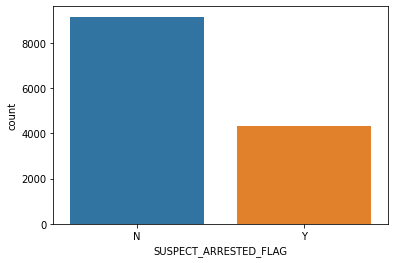

In [37]:
#imbalance in data
sns.countplot(x = "SUSPECT_ARRESTED_FLAG", data = stop_search_df)

Is the bias biased?


In [38]:
#does the data suggest racial bias?
#racial distribution of subjects stopped
stop_search_df["RACE"].value_counts()

Non-White    12159
White         1215
Unknown         85
Name: RACE, dtype: int64

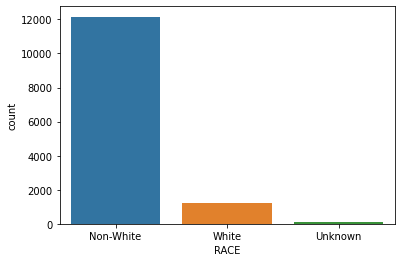

In [39]:
#racial distribution of subjects stopped
sns.countplot(x = "RACE", data = stop_search_df)

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text major ticklabel objects>)

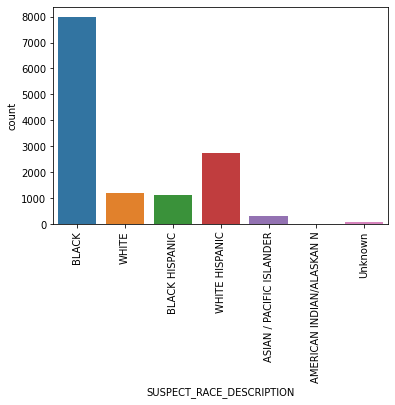

In [49]:
#racial distribution of subjects stopped
sns.countplot(x="SUSPECT_RACE_DESCRIPTION", data=stop_search_df)
plt.xticks(rotation=90)

In [40]:
#does the data suggest gender bias?
stop_search_df["SUSPECT_SEX"].value_counts()

MALE       12179
FEMALE      1230
Unknown       50
Name: SUSPECT_SEX, dtype: int64

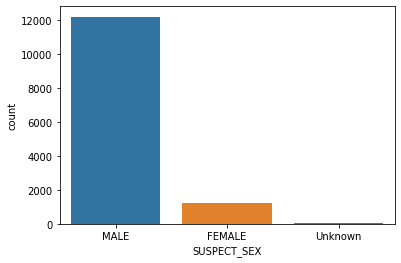

In [41]:
#count of different genders in the data
sns.countplot(x="SUSPECT_SEX", data=stop_search_df)

In [43]:
#gender distribution among the arrested subjects


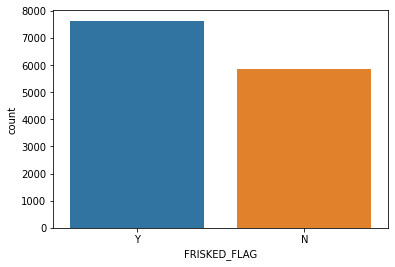

In [42]:
#frisk data
sns.countplot(x = "FRISKED_FLAG", data = stop_search_df)

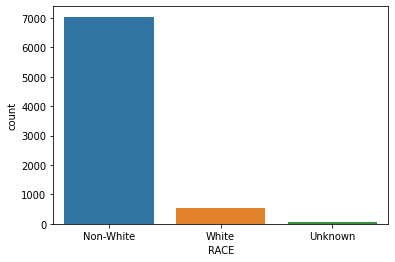

In [53]:
#racial distribution of subjects frisked
frisked_df = stop_search_df[stop_search_df["FRISKED_FLAG"] == "Y"]
sns.countplot(x = "RACE", data = frisked_df)

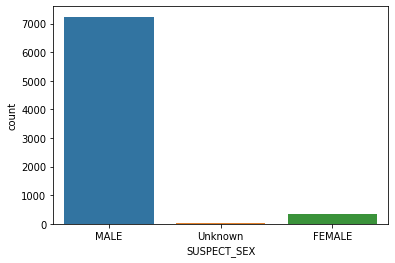

In [54]:
#gender distribution of subjects frisked
sns.countplot(x = "SUSPECT_SEX", data = frisked_df)

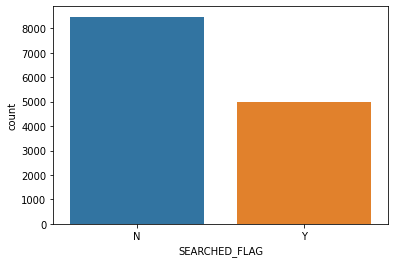

In [43]:
#searched data
sns.countplot(x = "SEARCHED_FLAG", data = stop_search_df)

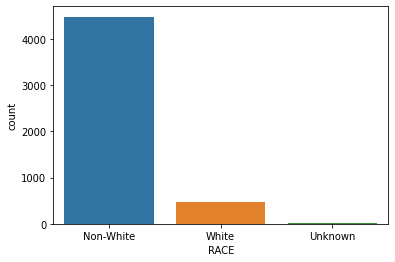

In [55]:
#racial distributions of subjects searched
searched_df = stop_search_df[stop_search_df["SEARCHED_FLAG"] == "Y"]
sns.countplot(x = "RACE", data = searched_df)

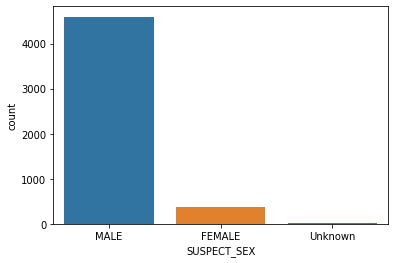

In [56]:
#gender distributions of subjects searched
sns.countplot(x = "SUSPECT_SEX", data = searched_df)

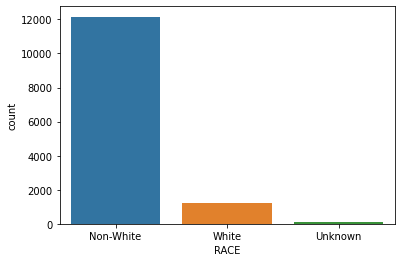

In [57]:
#veil of darkness
#racial distributions of subjects during day
day_df = stop_search_df[stop_search_df["Parts_of_day"] == "Day"]
sns.countplot(x = "RACE", data = day_df)

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text major ticklabel objects>)

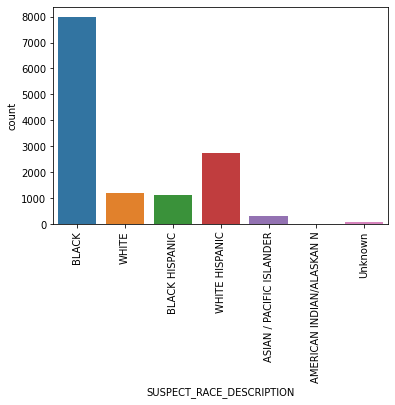

In [59]:
sns.countplot(x = "SUSPECT_RACE_DESCRIPTION", data = day_df)
plt.xticks(rotation=90)

In [62]:
night_df = stop_search_df[stop_search_df["Parts_of_day"] == "Night"]
# sns.countplot(x = "SUSPECT_RACE_DESCRIPTION", data = night_df)

In [64]:
stop_search_df["Parts_of_day"].value_counts()

Day    13459
Name: Parts_of_day, dtype: int64

In [ ]:
#racial distributions of subjects during night

Data Preprocessing:

In [ ]:
#target column
y_df = stop_search_df["SUSPECT_ARRESTED_FLAG"]
#label encoding target column
y_df = y_df.apply(LabelEncoder().fit_transform)

In [ ]:
#features
categorical_columns = ["SUSPECTED_CRIME_DESCRIPTION","SUSPECT_ARREST_OFFENSE","SUMMONS_ISSUED_FLAG","FRISKED_FLAG","SEARCHED_FLAG","OTHER_CONTRABAND_FLAG",
                       "WEAPON_FOUND_FLAG","SUSPECT_SEX","SUSPECT_RACE_DESCRIPTION","STOP_LOCATION_STREET_NAME"]
#one-hot encoding categorical input variables
x_df = pd.get_dummies(stop_search_df[categorical_columns])

In [ ]:
#features
numerical_columns = ["STOP_DURATION_MINUTES","SUSPECT_REPORTED_AGE"]

Objective:

We want to train a classification model to classify whether a subject stopped will be arrested or not. The objective is to analyze whether sensitive features like gender and race of the subject determines the outcome, arrest or no arrest.

The target/outcome variable is given by "SUSPECT_ARRESTED_FLAG" column in the dataset.


We will initially select important attributes about subject like gender, race, frisk, search, suspicion as the input variables to train the model.

Further, feature selection methods like Recursive Feature Elimination and GridSearchCV in scikit-learn will be used to find the important features for model training and performance.

Sensitive features:

In [1]:
#case 1 : racial bias
privileged_group = stop_search_df[stop_search_df["RACE"] == "Whites"]
underprivileged_group = stop_search_df[stop_search_df["RACE"] == "Non-Whites"]

In [ ]:
#case 2 : gender bias
privileged_group = stop_search_df[stop_search_df["SUSPECT_SEX"] == "FEMALE"]
underprivileged_group = stop_search_df[stop_search_df["SUSPECT_SEX"] == "MALE"]